# Text Classification Example

In [1]:
import itertools
import re

In [2]:
from dataset import news20
from nn.layer import *
from optim.optimizer import *
from util.common import *
from util.common import Sample

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
import pandas as pd

In [4]:
initEngine(1,4)

## 1. define some utility functions
* break the text corpus into tokens (words)

In [5]:
def text_to_words(review_text):
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    words = letters_only.lower().split()
    return words

* calcualte the frequency of words in each text corpus, sort by frequency, and assign an id to each word

In [6]:
def analyze_texts(data_rdd):
    return data_rdd.flatMap(lambda (text, label): text_to_words(text)) \
        .map(lambda word: (word, 1)).reduceByKey(lambda a, b: a + b) \
        .sortBy(lambda (w, c): - c).zipWithIndex() \
        .map(lambda ((w, c), i): (w, (i + 1, c))).collect()

* pad the embedding to required length

In [7]:
# pad([1, 2, 3, 4, 5], 0, 6)
def pad(l, fill_value, width):
    if len(l) >= width:
        return l[0: width]
    else:
        l.extend([fill_value] * (width - len(l)))
        return l

* word to vec

In [8]:
def to_vec(token, b_w2v, embedding_dim):
    if token in b_w2v:
        return b_w2v[token]
    else:
        return pad([], 0, embedding_dim)

* assemble the features (embeddings of words in each text sample) and label into samples

In [9]:
def to_sample(vectors, label, embedding_dim):
    # flatten nested list
    flatten_features = list(itertools.chain(*vectors))
    features = np.array(flatten_features, dtype='float').reshape(
        [sequence_len, embedding_dim]).transpose(1, 0)
    return Sample.from_ndarray(features, np.array(label))

In [10]:
def build_model(class_num):
    model = Sequential()

    model.add(Reshape([embedding_dim, 1, sequence_len]))
    model.add(SpatialConvolution(embedding_dim, 128, 5, 1))
    model.add(ReLU())
    model.add(SpatialMaxPooling(5, 1, 5, 1))
    model.add(SpatialConvolution(128, 128, 5, 1))
    model.add(ReLU())
    model.add(SpatialMaxPooling(5, 1, 5, 1))
    model.add(Reshape([128]))
    model.add(Linear(128, 100))
    model.add(Linear(100, class_num))
    model.add(LogSoftMax())
    return model

## 2. Training the model

* set some tunable parameters

In [11]:
batch_size = 128
embedding_dim = 50
sequence_len = 50
max_words = 1000
training_split = 0.8

* prepare samples

In [12]:
texts = news20.get_news20()
data_rdd = sc.parallelize(texts, 2)

word_to_ic = analyze_texts(data_rdd)
# Only take the top wc between [10, sequence_len]
word_to_ic = dict(word_to_ic[10: max_words])
bword_to_ic = sc.broadcast(word_to_ic)

w2v = news20.get_glove_w2v(dim=embedding_dim)
filtered_w2v = {w: v for w, v in w2v.items() if w in word_to_ic}
bfiltered_w2v = sc.broadcast(filtered_w2v)

tokens_rdd = data_rdd.map(lambda (text, label):
                              ([w for w in text_to_words(text) if
                                w in bword_to_ic.value], label))
padded_tokens_rdd = tokens_rdd.map(
        lambda (tokens, label): (pad(tokens, "##", sequence_len), label))

vector_rdd = padded_tokens_rdd.map(lambda (tokens, label):
                                       ([to_vec(w, bfiltered_w2v.value,
                                                embedding_dim) for w in
                                         tokens], label))
sample_rdd = vector_rdd.map(
        lambda (vectors, label): to_sample(vectors, label, embedding_dim))
print('Generated Samples')

Found 19997 texts.
Generated Samples


* split the samples into train and validation set 

In [13]:
#split train val sets
train_rdd, val_rdd = sample_rdd.randomSplit(
        [training_split, 1-training_split])

* configure optimizer

In [14]:
%%time
#configure states
state = {"batchSize": batch_size,
         "learningRate": 0.01,
         "learningRateDecay": 0.0002}
#configure optimizer
optimizer = Optimizer(
        model=build_model(news20.CLASS_NUM),
        training_rdd=train_rdd,
        criterion=ClassNLLCriterion(),
        end_trigger=MaxEpoch(2),
        batch_size=batch_size,
        optim_method="Adagrad",
        state=state)

optimizer.setvalidation(
    batch_size=batch_size,
        val_rdd=val_rdd,
        trigger=EveryEpoch(),
        val_method=["top1"]
)

creating: createSequential
creating: createReshape
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialMaxPooling
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialMaxPooling
creating: createReshape
creating: createLinear
creating: createLinear
creating: createLogSoftMax
creating: createClassNLLCriterion
creating: createMaxEpoch
creating: createOptimizer
creating: createEveryEpoch
CPU times: user 40 ms, sys: 36 ms, total: 76 ms
Wall time: 20.6 s


* Train the network. Wait some time till it finished.. Voila! You've got a trained model

In [15]:
%%time
trained_model = optimizer.optimize()
print "Optimization Done."

Optimization Done.
CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 31.9 s


## 3 Inspecting the prediction results

* Let's look closely on the predicted results of validation set

In [16]:
predictions = trained_model.predict(val_rdd)

In [17]:
def map_predict_label(l):
    return np.array(l).argmax()
def map_groundtruth_label(l):
    return l[0] - 1

In [18]:
y_pred = np.array([ map_predict_label(s.label) for s in predictions.collect()])

In [19]:
y_true = np.array([map_groundtruth_label(s.label) for s in val_rdd.collect()])

compute the confustion matrix and plot it

In [20]:
cm = confusion_matrix(y_true, y_pred)
cm.shape

(20, 20)

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


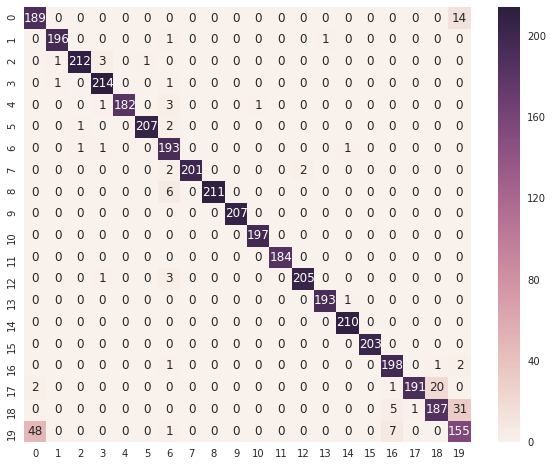

In [21]:
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True,fmt='d')